# Time Series Forecasting with py-tidymodels

This notebook demonstrates time series forecasting using three different model types:
1. **Linear Regression** - Simple trend model
2. **Prophet** - Facebook's time series forecaster
3. **ARIMA** - Classic statistical time series model

All models use the same unified interface through py-parsnip!

In [15]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime, timedelta

sys.path.insert(0, '..')

from py_parsnip import linear_reg, prophet_reg, arima_reg

## Create Synthetic Time Series Data

Let's create realistic sales data with:
- Linear trend
- Seasonal pattern (yearly)
- Random noise

In [16]:
# Set seed for reproducibility
np.random.seed(42)

# Create 3 years of daily data
n_days = 365 * 3
dates = pd.date_range(start='2020-01-01', periods=n_days, freq='D')

# Components
t = np.arange(n_days)
trend = 100 + 0.05 * t  # Linear growth
seasonality = 20 * np.sin(2 * np.pi * t / 365)  # Yearly seasonality
noise = np.random.normal(0, 5, n_days)  # Random fluctuations

sales = trend + seasonality + noise

# Create DataFrame
data = pd.DataFrame({
    'date': dates,
    'sales': sales
})

print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nLast few rows:")
print(data.tail())

Data shape: (1095, 2)

First few rows:
        date       sales
0 2020-01-01  102.483571
1 2020-01-02   99.702946
2 2020-01-03  104.026875
3 2020-01-04  108.797543
4 2020-01-05  100.405282

Last few rows:
           date       sales
1090 2022-12-26  152.422698
1091 2022-12-27  152.987840
1092 2022-12-28  157.205754
1093 2022-12-29  154.221297
1094 2022-12-30  158.018933


## Train/Test Split

For time series, we use chronological splitting:
- Train: First 2.5 years
- Test: Last 6 months

In [17]:
# Split at 2.5 years
split_date = '2022-07-01'

train = data[data['date'] < split_date].copy()
test = data[data['date'] >= split_date].copy()

print(f"Training: {len(train)} days ({train['date'].min()} to {train['date'].max()})")
print(f"Testing: {len(test)} days ({test['date'].min()} to {test['date'].max()})")

Training: 912 days (2020-01-01 00:00:00 to 2022-06-30 00:00:00)
Testing: 183 days (2022-07-01 00:00:00 to 2022-12-30 00:00:00)


## Model 1: Linear Regression

Simple approach: predict sales from time index

In [18]:
# Add time index for linear regression
train['time_idx'] = np.arange(len(train))
test['time_idx'] = np.arange(len(train), len(train) + len(test))

# Create and fit linear regression model
lr_spec = linear_reg()
lr_fit = lr_spec.fit(train, "sales ~ time_idx")

# Evaluate on test data
lr_fit = lr_fit.evaluate(test)

print("Linear Regression fitted and evaluated!")
print(f"Model class: {lr_fit.fit_data['model_class']}")

# Extract comprehensive outputs
outputs, coefs, stats = lr_fit.extract_outputs()

print("\n" + "="*60)
print("COEFFICIENTS - Enhanced with statistical inference")
print("="*60)
print(coefs[['variable', 'coefficient', 'std_error', 'p_value']].to_string(index=False))

Linear Regression fitted and evaluated!
Model class: LinearRegression

COEFFICIENTS - Enhanced with statistical inference
 variable  coefficient  std_error  p_value
Intercept     0.000000   8.413357 1.000000
 time_idx     0.050933   0.015992 0.001497


In [19]:
outputs

,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,102.483571,102.233315,102.233315,102.483571,train,linear_reg,,global
1,99.702946,102.284248,102.284248,99.702946,train,linear_reg,,global
2,104.026875,102.335181,102.335181,104.026875,train,linear_reg,,global
3,108.797543,102.386114,102.386114,108.797543,train,linear_reg,,global
4,100.405282,102.437047,102.437047,100.405282,train,linear_reg,,global
...,...,...,...,...,...,...,...,...
1090,152.422698,NaN,157.750220,-5.327523,test,linear_reg,,global
1091,152.987840,NaN,157.801153,-4.813313,test,linear_reg,,global
1092,157.205754,NaN,157.852086,-0.646332,test,linear_reg,,global
1093,154.221297,NaN,157.903019,-3.681722,test,linear_reg,,global


In [20]:
coefs

,variable,coefficient,std_error,t_stat,p_value,ci_0.025,ci_0.975,vif,model,model_group_name,group
0,Intercept,0.000000,8.413357,0.000000,1.000000,-16.511838,16.511838,NaN,linear_reg,,global
1,time_idx,0.050933,0.015992,3.184977,0.001497,0.019548,0.082318,1.0,linear_reg,,global


In [21]:
stats

,metric,value,split,model,model_group_name,group
0,rmse,14.72007,train,linear_reg,,global
1,mae,12.711505,train,linear_reg,,global
2,mape,10.586528,train,linear_reg,,global
3,smape,10.340062,train,linear_reg,,global
4,r_squared,0.453499,train,linear_reg,,global
5,mda,50.823271,train,linear_reg,,global
6,adj_r_squared,0.452297,train,linear_reg,,global
7,rmse,17.27446,test,linear_reg,,global
8,mae,15.515812,test,linear_reg,,global
9,mape,11.5983,test,linear_reg,,global


In [22]:
# Show comprehensive metrics by split
print("="*60)
print("STATS - Comprehensive metrics by train/test split")
print("="*60)

# Performance metrics
perf_metrics = ['rmse', 'mae', 'mape', 'r_squared', 'mda']
perf_stats = stats[stats['metric'].isin(perf_metrics)]

for split in ['train', 'test']:
    print(f"\n{split.upper()}:")
    split_stats = perf_stats[perf_stats['split'] == split]
    for _, row in split_stats.iterrows():
        print(f"  {row['metric']:15s}: {row['value']:8.2f}")

print("\n" + "="*60)
print("OUTPUTS - Observation-level results")
print("="*60)
print(f"Total observations: {len(outputs)}")
print(f"Training observations: {len(outputs[outputs['split'] == 'train'])}")
print(f"Test observations: {len(outputs[outputs['split'] == 'test'])}")
print("\nSample test predictions:")
print(outputs[outputs['split'] == 'test'][['actuals', 'forecast', 'residuals']].head())

STATS - Comprehensive metrics by train/test split

TRAIN:
  rmse           :    14.72
  mae            :    12.71
  mape           :    10.59
  r_squared      :     0.45
  mda            :    50.82

TEST:
  rmse           :    17.27
  mae            :    15.52
  mape           :    11.60
  r_squared      :    -3.45
  mda            :    50.55

OUTPUTS - Observation-level results
Total observations: 1095
Training observations: 912
Test observations: 183

Sample test predictions:
        actuals    forecast  residuals
912  147.019058  148.684157  -1.665099
913  153.365126  148.735090   4.630037
914  144.707154  148.786023  -4.078869
915  146.284663  148.836956  -2.552293
916  147.635217  148.887889  -1.252672


## Model 2: Prophet

Prophet automatically handles:
- Trend changes
- Multiple seasonalities
- Holidays (if provided)

In [32]:
# Create and fit Prophet model
prophet_spec = prophet_reg(
    growth='linear',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

prophet_fit = prophet_spec.fit(train[['date', 'sales']], "sales ~ date")

# Evaluate on test data
prophet_fit = prophet_fit.evaluate(test[['date', 'sales']])

print("Prophet fitted and evaluated!")
print(f"N obs: {prophet_fit.fit_data['n_obs']}")

# Extract comprehensive outputs
outputs, coefs, stats = prophet_fit.extract_outputs()

print("\n" + "="*60)
print("COEFFICIENTS - Prophet Hyperparameters")
print("="*60)
print(coefs[['variable', 'coefficient']].to_string(index=False))

Prophet fitted and evaluated!
N obs: 912

COEFFICIENTS - Prophet Hyperparameters
               variable coefficient
                 growth      linear
changepoint_prior_scale        0.05
seasonality_prior_scale        10.0
       seasonality_mode    additive
         n_changepoints          25


In [24]:
# Show comprehensive metrics by split
print("="*60)
print("STATS - Comprehensive metrics by train/test split")
print("="*60)

# Performance metrics
perf_metrics = ['rmse', 'mae', 'mape', 'smape', 'r_squared', 'mda']
perf_stats = stats[stats['metric'].isin(perf_metrics)]

for split in ['train', 'test']:
    print(f"\n{split.upper()}:")
    split_stats = perf_stats[perf_stats['split'] == split]
    for _, row in split_stats.iterrows():
        print(f"  {row['metric']:15s}: {row['value']:8.2f}")

# Residual diagnostics
print("\n\nRESIDUAL DIAGNOSTICS (Training):")
resid_metrics = ['durbin_watson', 'shapiro_wilk_stat', 'shapiro_wilk_p']
resid_stats = stats[stats['metric'].isin(resid_metrics)]
for _, row in resid_stats.iterrows():
    print(f"  {row['metric']:20s}: {row['value']:8.4f}")

print("\n" + "="*60)
print("OUTPUTS - Date-indexed observation-level results")
print("="*60)
print(f"Total observations: {len(outputs)}")
print(f"Training: {len(outputs[outputs['split'] == 'train'])} | Test: {len(outputs[outputs['split'] == 'test'])}")
print("\nSample test forecasts:")
print(outputs[outputs['split'] == 'test'][['date', 'actuals', 'forecast', 'residuals']].head())

STATS - Comprehensive metrics by train/test split

TRAIN:
  rmse           :     4.82
  mae            :     3.82
  mape           :     3.12
  smape          :     3.12
  r_squared      :     0.94
  mda            :    53.46

TEST:
  rmse           :     5.30
  mae            :     4.16
  mape           :     3.09
  smape          :     3.04
  r_squared      :     0.58
  mda            :    56.04


RESIDUAL DIAGNOSTICS (Training):
  durbin_watson       :   2.0688
  shapiro_wilk_stat   :   0.9974
  shapiro_wilk_p      :   0.1485

OUTPUTS - Date-indexed observation-level results
Total observations: 1095
Training: 912 | Test: 183

Sample test forecasts:
          date     actuals    forecast  residuals
912 2022-07-01  147.019058  146.763944   0.255115
913 2022-07-02  153.365126  147.024553   6.340573
914 2022-07-03  144.707154  146.199456  -1.492302
915 2022-07-04  146.284663  146.476511  -0.191848
916 2022-07-05  147.635217  146.211119   1.424098


In [33]:
outputs

,date,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2020-01-01,102.483571,101.052275,101.052275,1.431296,train,prophet_reg,,global
1,2020-01-02,99.702946,101.407440,101.407440,-1.704494,train,prophet_reg,,global
2,2020-01-03,104.026875,100.817467,100.817467,3.209408,train,prophet_reg,,global
3,2020-01-04,108.797543,101.739123,101.739123,7.058420,train,prophet_reg,,global
4,2020-01-05,100.405282,101.548226,101.548226,-1.142944,train,prophet_reg,,global
...,...,...,...,...,...,...,...,...,...
1090,2022-12-26,152.422698,NaN,156.353753,-3.931055,test,prophet_reg,,global
1091,2022-12-27,152.987840,NaN,156.909478,-3.921638,test,prophet_reg,,global
1092,2022-12-28,157.205754,NaN,157.570339,-0.364585,test,prophet_reg,,global
1093,2022-12-29,154.221297,NaN,158.022656,-3.801359,test,prophet_reg,,global


In [34]:
stats


,metric,value,split,model,model_group_name,group
0,rmse,4.818435,train,prophet_reg,,global
1,mae,3.822116,train,prophet_reg,,global
2,mape,3.123169,train,prophet_reg,,global
3,smape,3.117754,train,prophet_reg,,global
4,r_squared,0.941442,train,prophet_reg,,global
5,mda,53.457739,train,prophet_reg,,global
6,rmse,5.30214,test,prophet_reg,,global
7,mae,4.164835,test,prophet_reg,,global
8,mape,3.090743,test,prophet_reg,,global
9,smape,3.038661,test,prophet_reg,,global


In [35]:
coefs

,variable,coefficient,std_error,t_stat,p_value,ci_0.025,ci_0.975,vif,model,model_group_name,group
0,growth,linear,NaN,NaN,NaN,NaN,NaN,NaN,prophet_reg,,global
1,changepoint_prior_scale,0.05,NaN,NaN,NaN,NaN,NaN,NaN,prophet_reg,,global
2,seasonality_prior_scale,10.0,NaN,NaN,NaN,NaN,NaN,NaN,prophet_reg,,global
3,seasonality_mode,additive,NaN,NaN,NaN,NaN,NaN,NaN,prophet_reg,,global
4,n_changepoints,25,NaN,NaN,NaN,NaN,NaN,NaN,prophet_reg,,global


## Model 3: ARIMA

Classic statistical approach using SARIMA(1,1,1)(0,0,0)[0]

In [36]:
# Create and fit ARIMA model
arima_spec = arima_reg(
    non_seasonal_ar=1,
    non_seasonal_differences=1,
    non_seasonal_ma=1
)

arima_fit = arima_spec.fit(train[['date', 'sales']], "sales ~ 1")

# Evaluate on test data
arima_fit = arima_fit.evaluate(test[['date', 'sales']])

print("ARIMA fitted and evaluated!")

# Extract comprehensive outputs
outputs, coefs, stats = arima_fit.extract_outputs()

print(f"Order: {arima_fit.fit_data['order']}")
print(f"Seasonal order: {arima_fit.fit_data['seasonal_order']}")

print("\n" + "="*60)
print("COEFFICIENTS - ARIMA parameters with p-values")
print("="*60)
print(coefs[['variable', 'coefficient', 'std_error', 'p_value']].to_string(index=False))

ARIMA fitted and evaluated!
Order: (1, 1, 1)
Seasonal order: (0, 0, 0, 0)

COEFFICIENTS - ARIMA parameters with p-values
variable  coefficient  std_error       p_value
   ar.L1    -0.059317   0.040655  1.445496e-01
   ma.L1    -0.789781   0.025600 5.384625e-209
  sigma2    28.136614   1.332377  5.479995e-99


In [26]:
# Show comprehensive metrics by split
print("="*60)
print("STATS - Comprehensive metrics by train/test split")
print("="*60)

# Performance metrics
perf_metrics = ['rmse', 'mae', 'mape', 'smape', 'r_squared', 'mda']
perf_stats = stats[stats['metric'].isin(perf_metrics)]

for split in ['train', 'test']:
    print(f"\n{split.upper()}:")
    split_stats = perf_stats[perf_stats['split'] == split]
    for _, row in split_stats.iterrows():
        print(f"  {row['metric']:15s}: {row['value']:8.2f}")

# Model information
print("\n\nMODEL INFORMATION:")
info_metrics = ['aic', 'bic']
info_stats = stats[stats['metric'].isin(info_metrics)]
for _, row in info_stats.iterrows():
    print(f"  {row['metric'].upper():20s}: {row['value']:8.2f}")

# Residual diagnostics
print("\nRESIDUAL DIAGNOSTICS (Training):")
resid_metrics = ['durbin_watson', 'shapiro_wilk_stat', 'shapiro_wilk_p']
resid_stats = stats[stats['metric'].isin(resid_metrics)]
for _, row in resid_stats.iterrows():
    print(f"  {row['metric']:20s}: {row['value']:8.4f}")

print("\n" + "="*60)
print("OUTPUTS - Date-indexed observation-level results")
print("="*60)
print(f"Total observations: {len(outputs)}")
print(f"Training: {len(outputs[outputs['split'] == 'train'])} | Test: {len(outputs[outputs['split'] == 'test'])}")
print("\nSample test forecasts:")
print(outputs[outputs['split'] == 'test'][['date', 'actuals', 'forecast', 'residuals']].head())

STATS - Comprehensive metrics by train/test split

TRAIN:
  rmse           :     6.29
  mae            :     4.32
  mape           :     3.54
  smape          :     3.65
  r_squared      :     0.90
  mda            :    28.32

TEST:
  rmse           :    13.92
  mae            :    12.13
  mape           :     9.10
  smape          :     8.59
  r_squared      :    -1.89
  mda            :    50.00


MODEL INFORMATION:
  AIC                 :  5619.52
  BIC                 :  5633.96

RESIDUAL DIAGNOSTICS (Training):
  durbin_watson       :   1.7098
  shapiro_wilk_stat   :   0.8055
  shapiro_wilk_p      :   0.0000

OUTPUTS - Date-indexed observation-level results
Total observations: 1095
Training: 912 | Test: 183

Sample test forecasts:
          date     actuals    forecast  residuals
912 2022-07-01  147.019058  149.259300  -2.240241
913 2022-07-02  153.365126  149.134901   4.230226
914 2022-07-03  144.707154  149.142280  -4.435126
915 2022-07-04  146.284663  149.141842  -2.857179
916 

## Model Comparison

Let's compare all three models side by side

In [37]:
# Create comparison DataFrame using comprehensive stats
# Extract test RMSE from each model's stats DataFrame
lr_outputs, lr_coefs, lr_stats = lr_fit.extract_outputs()
prophet_outputs, prophet_coefs, prophet_stats = prophet_fit.extract_outputs()
arima_outputs, arima_coefs, arima_stats = arima_fit.extract_outputs()

lr_rmse = lr_stats[(lr_stats['metric'] == 'rmse') & (lr_stats['split'] == 'test')]['value'].values[0]
prophet_rmse = prophet_stats[(prophet_stats['metric'] == 'rmse') & (prophet_stats['split'] == 'test')]['value'].values[0]
arima_rmse = arima_stats[(arima_stats['metric'] == 'rmse') & (arima_stats['split'] == 'test')]['value'].values[0]

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Prophet', 'ARIMA'],
    'RMSE': [lr_rmse, prophet_rmse, arima_rmse],
    'Has Intervals': ['No', 'Yes', 'Yes']
})

comparison = comparison.sort_values('RMSE')

print("Model Performance Comparison (Test RMSE):")
print(comparison.to_string(index=False))

Model Performance Comparison (Test RMSE):
            Model      RMSE Has Intervals
          Prophet  5.302140           Yes
            ARIMA 13.919579           Yes
Linear Regression 17.274460            No


## Visualize Predictions

Let's plot actual vs predicted for all models

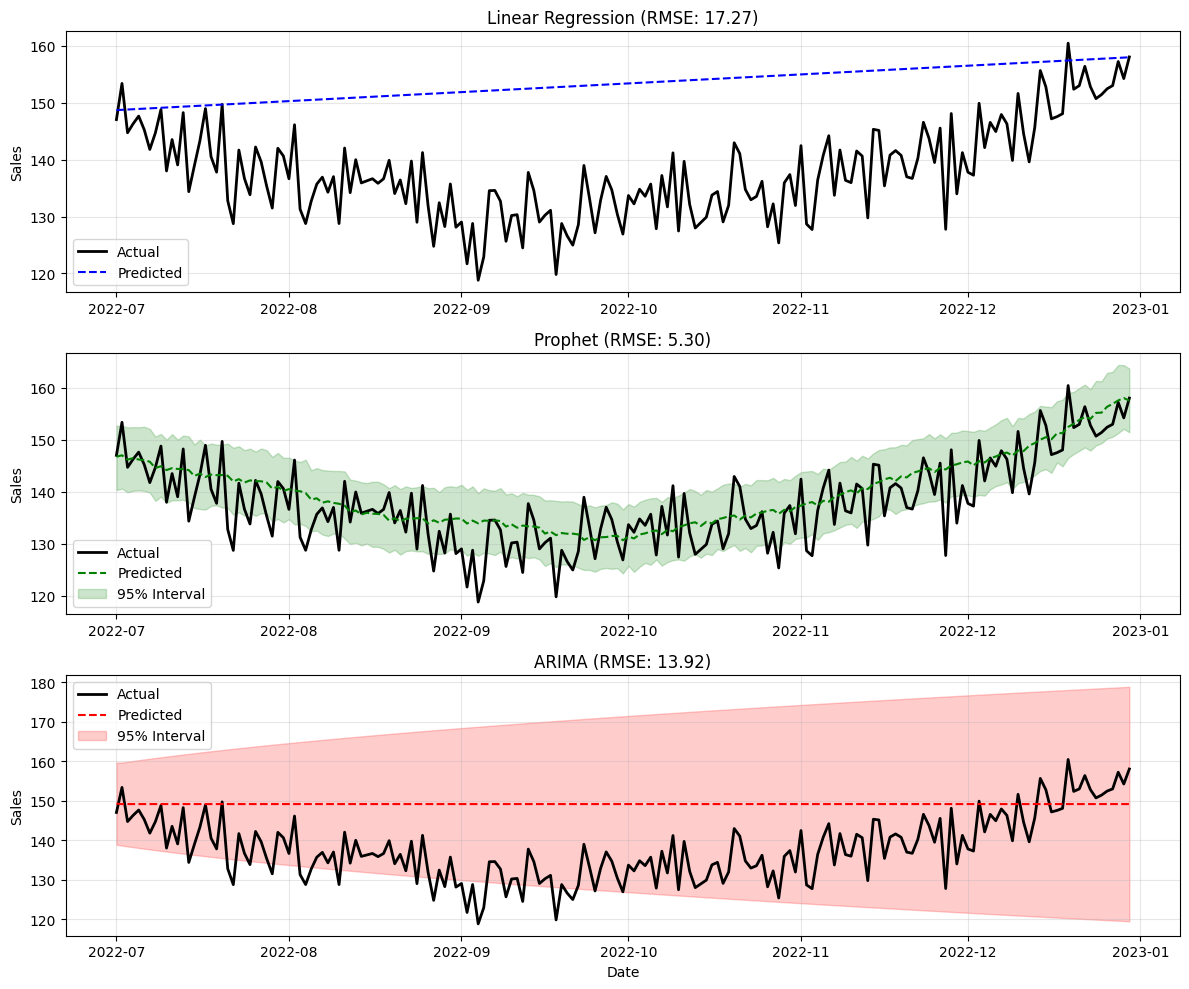

In [28]:
import matplotlib.pyplot as plt

# Extract test data from comprehensive outputs
lr_test = lr_outputs[lr_outputs['split'] == 'test']
prophet_test = prophet_outputs[prophet_outputs['split'] == 'test']
arima_test = arima_outputs[arima_outputs['split'] == 'test']

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Linear Regression (use test dates since lr doesn't store dates)
axes[0].plot(test['date'], lr_test['actuals'].values, label='Actual', color='black', linewidth=2)
axes[0].plot(test['date'], lr_test['forecast'].values, label='Predicted', color='blue', linestyle='--')
axes[0].set_title(f'Linear Regression (RMSE: {lr_rmse:.2f})')
axes[0].set_ylabel('Sales')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Prophet (with intervals from predict)
prophet_preds = prophet_fit.predict(test[['date']], type='conf_int')
axes[1].plot(prophet_test['date'].values, prophet_test['actuals'].values, label='Actual', color='black', linewidth=2)
axes[1].plot(prophet_test['date'].values, prophet_test['forecast'].values, label='Predicted', color='green', linestyle='--')
axes[1].fill_between(
    prophet_test['date'].values, 
    prophet_preds['.pred_lower'].values, 
    prophet_preds['.pred_upper'].values,
    alpha=0.2, color='green', label='95% Interval'
)
axes[1].set_title(f'Prophet (RMSE: {prophet_rmse:.2f})')
axes[1].set_ylabel('Sales')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: ARIMA (with intervals from predict)
arima_preds = arima_fit.predict(test[['date']], type='conf_int')
axes[2].plot(arima_test['date'].values, arima_test['actuals'].values, label='Actual', color='black', linewidth=2)
axes[2].plot(arima_test['date'].values, arima_test['forecast'].values, label='Predicted', color='red', linestyle='--')
axes[2].fill_between(
    arima_test['date'].values, 
    arima_preds['.pred_lower'].values, 
    arima_preds['.pred_upper'].values,
    alpha=0.2, color='red', label='95% Interval'
)
axes[2].set_title(f'ARIMA (RMSE: {arima_rmse:.2f})')
axes[2].set_ylabel('Sales')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<cell_type>markdown</cell_type>## Key Takeaways

**Unified Interface:**
```python
# All models follow the same pattern:
spec = model_function(parameters)
fit = spec.fit(data, formula)
fit = fit.evaluate(test_data)  # NEW: Comprehensive train/test evaluation
outputs, coefs, stats = fit.extract_outputs()  # NEW: Three-DataFrame output
```

**Comprehensive Output Structure:**

1. **Outputs DataFrame**: Observation-level results with dates
   - `date`: Timestamp for time series models
   - `actuals`: Actual values
   - `fitted`: In-sample predictions (training)
   - `forecast`: Out-of-sample predictions (test)
   - `residuals`: Actuals - Predictions
   - `split`: train/test indicator

2. **Coefficients DataFrame**: Model parameters with statistical inference
   - Linear Regression: Coefficients with p-values, CI, VIF
   - Prophet: Hyperparameters (growth, changepoint_prior_scale, etc.)
   - ARIMA: AR/MA parameters with p-values from statsmodels

3. **Stats DataFrame**: Comprehensive metrics by split
   - Performance: RMSE, MAE, MAPE, SMAPE, R², MDA
   - Residual diagnostics: Durbin-Watson, Shapiro-Wilk
   - Model information: AIC, BIC (ARIMA), formula, dates

**Model Selection:**
- **Linear Regression**: Simple, interpretable, but doesn't capture seasonality
- **Prophet**: Best for data with strong seasonal patterns and trend changes
- **ARIMA**: Classic statistical approach, provides p-values for parameters

**Next Steps:**
1. Add external regressors (price, promotions)
2. Implement time series cross-validation (py-rsample)
3. Compare multiple models with WorkflowSets (Phase 2)
4. Create ensembles with py-stacks (Phase 3)